In [1]:
from moarchiving.get_archive import get_archive
from moarchiving.moarchiving_utils import my_lexsort
from point_sampling import get_non_dominated_points

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import time
import numpy as np
import os
import copy

In [2]:
def plot_performance(f_name=None, plot_function="add", poly_degree=2, xlabel="Archive size",
                     ylabel="Time [s]", title="", logx=True, logy=True, colors=None):
    if f_name is None:
        f_names = os.listdir("test_results")
        f_names = [f for f in f_names if plot_function in f]
        f_names.sort()
        f_name = f_names[-1]

    df = pd.read_csv(f"test_results/{f_name}", index_col=0)
    print(df)

    if colors is None:
        colors = list(mcolors.TABLEAU_COLORS.keys())

    fig, ax = plt.subplots()

    for i, col in enumerate(df.columns):
        # make polynomial fit ignoring the nan values
        y = df[col]
        # shorten the data to the first nan value
        if np.isnan(y).any():
            idx = np.where(np.isnan(y))[0][0]
            y = y[:idx]
        x = df.index[:len(y)]

        # p = np.polyfit(x, y, poly_degree)
        ax.plot(x, y, '-o', label=col, color=colors[i])
        # ax.plot(x, np.polyval(p, x), '--', color=colors[i], alpha=0.4,
        #         label=f"{p[0]:.2E} x^{poly_degree} + O(x^{poly_degree-1})")

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")
    plt.legend()
    plt.grid()
    plt.title(f"{plot_function}: ({f_name[(len(plot_function)+1):-4]}) \n{title}")
    plt.show()


In [3]:
def save_results(data, index, n_dim, function):
    df = pd.DataFrame(data, index=index)
    date = time.strftime("%m%d-%H%M%S")
    df.to_csv(f"test_results/{function}_{n_dim}D_{date}.csv")

In [4]:
archive_sizes = [2 ** i for i in range(21)]
# check if directory test_results exists
if not os.path.exists("test_results"):
    os.makedirs("test_results")

In [5]:
def test_add(test_archive_sizes, n_repeats=10, n_dim=3, time_limit=10):
    ref_point = [1] * n_dim

    times = []
    archive_sizes_tested = []
    print("TEST ADD", n_dim)
    print(f"{'num points':10} | {'one by one':10} |")

    for archive_size in test_archive_sizes:
        moa = [get_archive(get_non_dominated_points(archive_size, n_dim=n_dim), ref_point, n_obj=n_dim)
               for _ in range(n_repeats)]

        add_points = get_non_dominated_points(n_repeats, n_dim=n_dim)
        t0 = time.time()
        for i in range(n_repeats):
            moa[i].add(add_points[i])
        t1 = time.time()

        times.append((t1 - t0) / n_repeats)
        archive_sizes_tested.append(archive_size)

        print(f"{archive_size:10} | {t1 - t0:.8f} |")
        if t1 - t0 > time_limit:
            break
    
    save_results(data={"times": times}, index=archive_sizes_tested, n_dim=n_dim, function="add")



# Test adding points to the archive

TEST ADD 3
num points | one by one |
         1 | 0.00099587 |
         2 | 0.00099730 |
         4 | 0.00399804 |
         8 | 0.00598550 |
        16 | 0.00995016 |
        32 | 0.01795530 |
        64 | 0.03593564 |
       128 | 0.08975959 |
       256 | 0.15555215 |
       512 | 0.35303330 |
      1024 | 0.61635065 |
      2048 | 1.21571541 |
      4096 | 3.41186619 |
      8192 | 4.92382789 |
     16384 | 9.92045784 |
     32768 | 20.09245467 |
          times
1      0.000100
2      0.000100
4      0.000400
8      0.000599
16     0.000995
32     0.001796
64     0.003594
128    0.008976
256    0.015555
512    0.035303
1024   0.061635
2048   0.121572
4096   0.341187
8192   0.492383
16384  0.992046
32768  2.009245


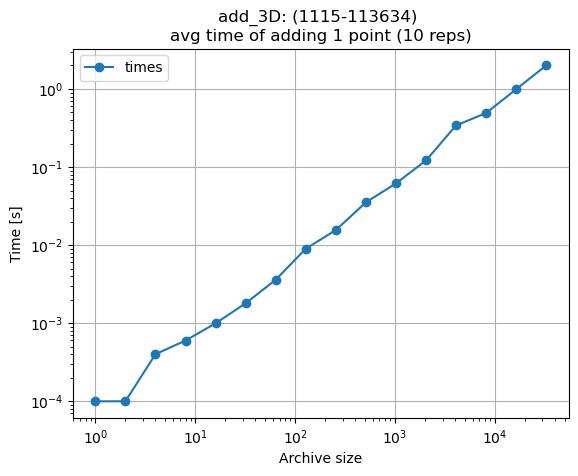

TEST ADD 4
num points | one by one |
         1 | 0.00199461 |
         2 | 0.00299191 |
         4 | 0.00698113 |
         8 | 0.01894951 |
        16 | 0.06286240 |
        32 | 0.23534632 |
        64 | 0.73004460 |
       128 | 2.90252924 |
       256 | 9.41480827 |
       512 | 30.70523930 |
        times
1    0.000199
2    0.000299
4    0.000698
8    0.001895
16   0.006286
32   0.023535
64   0.073004
128  0.290253
256  0.941481
512  3.070524


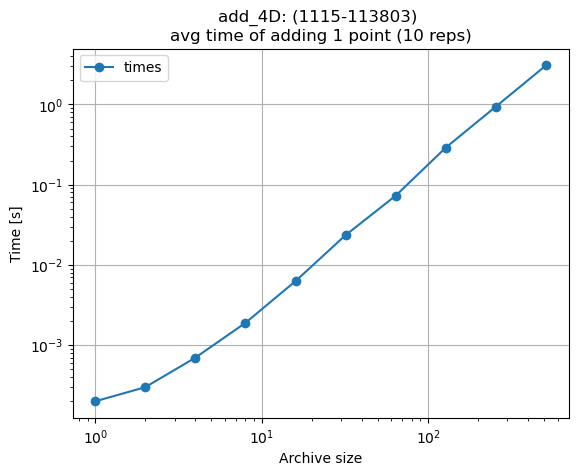

In [6]:

test_add(test_archive_sizes=archive_sizes, n_dim=3, time_limit=10)
plot_performance(plot_function="add_3D", title="avg time of adding 1 point (10 reps)")

test_add(test_archive_sizes=archive_sizes, n_dim=4, time_limit=10)
plot_performance(plot_function="add_4D", title="avg time of adding 1 point (10 reps)")


# Compare the time of adding different amount of points to the archive

In [7]:
def test_add_n_points(test_archive_sizes, test_n_points, n_dim=3, time_limit=10):
    ref_point = [1] * n_dim

    times_one_by_one = {
        n_points: [] for n_points in test_n_points
    }
    times_reinitialize = {
        n_points: [] for n_points in test_n_points
    }
    times_compare = {
        n_points: [] for n_points in test_n_points
    }
    archive_sizes_tested = []
    print("TEST ADD N POINTS", n_dim)
    print(f"{'num points':10} | {'one by one':10} | {'reinit':10} |")

    for archive_size in test_archive_sizes:
        for n_points in test_n_points:
            points = get_non_dominated_points(archive_size, n_dim=n_dim)

            moa_one_by_one = get_archive(copy.deepcopy(points), ref_point, n_obj=n_dim)
            moa_reinitialize = get_archive(copy.deepcopy(points), ref_point, n_obj=n_dim)
            moa_compare = get_archive(copy.deepcopy(points), ref_point, n_obj=n_dim)

            add_points = get_non_dominated_points(n_points, n_dim=n_dim)

            t0 = time.time()
            moa_one_by_one.add_list(add_points, add_method="one_by_one")
            t1 = time.time()
            moa_reinitialize.add_list(add_points, add_method="reinit")
            t2 = time.time()
            moa_compare.add_list(add_points)
            t3 = time.time()

            times_one_by_one[n_points].append(max(t1 - t0, 10e-4))
            times_reinitialize[n_points].append(max(t2 - t1, 10e-4))
            times_compare[n_points].append(max(t3 - t2, 10e-4))

        archive_sizes_tested.append(archive_size)
        print(f"{archive_size:10} | {times_one_by_one[test_n_points[-1]][-1]:.8f} | "
              f"{times_reinitialize[test_n_points[-1]][-1]:.8f} |")
        if (times_one_by_one[test_n_points[-1]][-1] > time_limit or
                times_reinitialize[test_n_points[-1]][-1] > time_limit or
                times_compare[test_n_points[-1]][-1] > time_limit):
            print("TIME LIMIT REACHED")
            break

    data = {}
    for n_points in test_n_points:
        data[f"one_by_one_{n_points}"] = times_one_by_one[n_points]
        data[f"reinitialize_{n_points}"] = times_reinitialize[n_points]
        data[f"compare_{n_points}"] = times_compare[n_points]

    save_results(data=data, index=archive_sizes_tested, n_dim=n_dim, function="add_n_points")


TEST ADD N POINTS 3
num points | one by one | reinit     |
         1 | 0.03288507 | 0.01097274 |
         2 | 0.03191423 | 0.00997329 |
         4 | 0.02692795 | 0.00897574 |
         8 | 0.02892232 | 0.00797892 |
        16 | 0.03291249 | 0.01196837 |
        32 | 0.03892684 | 0.00997424 |
        64 | 0.05186582 | 0.01296544 |
       128 | 0.07679772 | 0.01695657 |
       256 | 0.12067699 | 0.02692795 |
       512 | 0.22040725 | 0.04786944 |
      1024 | 0.41093326 | 0.08876538 |
      2048 | 0.85474467 | 0.16954637 |
      4096 | 1.64061642 | 0.41489005 |
      8192 | 4.23566866 | 1.03124142 |
     16384 | 7.52882552 | 1.66155648 |
     32768 | 15.14245915 | 3.61835194 |
     65536 | 32.22084093 | 7.28654027 |
    131072 | 62.41612959 | 14.19502401 |
TIME LIMIT REACHED
        one_by_one_1  reinitialize_1  compare_1  one_by_one_10  \
1           0.001000        0.001000   0.001000       0.001995   
2           0.001000        0.001000   0.001000       0.001000   
4           0.0010

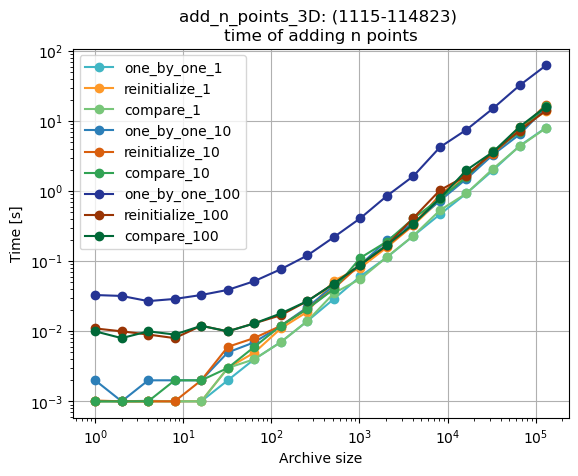

In [8]:
test_add_n_points(test_archive_sizes=archive_sizes, test_n_points=[1, 10, 100],
                  n_dim=3, time_limit=60)
plot_performance(plot_function=f"add_n_points_3D", 
                 colors=['#41b6c4', '#fe9929', '#78c679', '#2c7fb8', '#d95f0e', '#31a354', '#253494', '#993404', '#006837'],
                 title=f"time of adding n points")

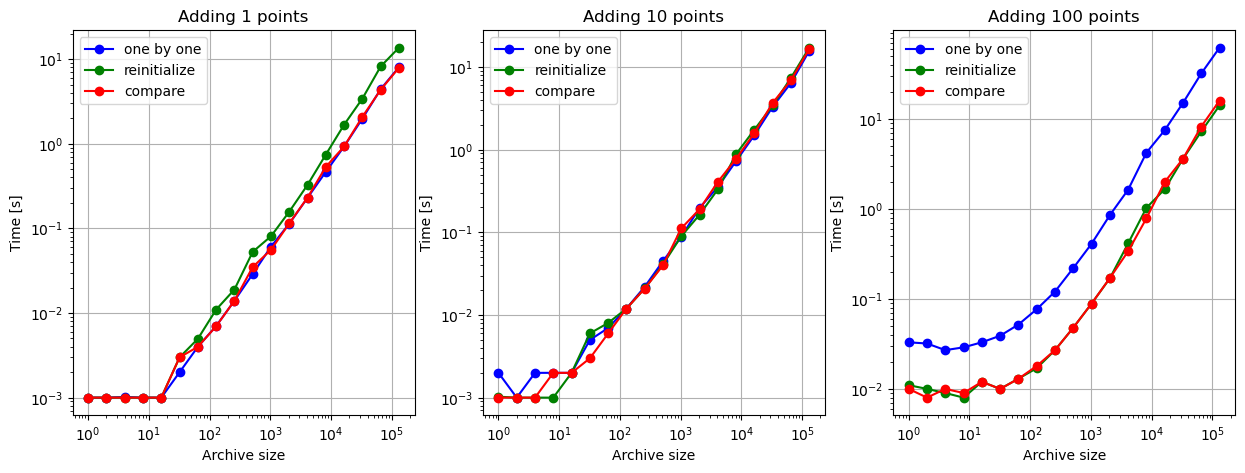

In [9]:
plot_function="add_n_points_3D"
colors=['blue', 'green', 'red']
title=f"time of adding n points"

f_names = os.listdir("test_results")
f_names = [f for f in f_names if plot_function in f]
f_names.sort()
f_name = f_names[-1]

df = pd.read_csv(f"test_results/{f_name}", index_col=0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for ax_idx in range(3):
    ax = axs[ax_idx]

    for i, col in enumerate(df.columns[ax_idx*3:(ax_idx+1)*3]):
        y = df[col]
        # shorten the data to the first nan value
        if np.isnan(y).any():
            idx = np.where(np.isnan(y))[0][0]
            y = y[:idx]
        x = df.index[:len(y)]
        col_name = " ".join(col.split("_")[:-1])
        ax.plot(x, y, '-o', label=col_name, color=colors[i])

    ax.set_xlabel("Archive size")
    ax.set_ylabel("Time [s]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid()
    ax.legend()
    ax.set_title(f"Adding {10**ax_idx} points")
plt.show()


In [10]:
def test_kink_points(test_archive_sizes, n_dim=3, time_limit=10):
    print("TEST KINK POINTS")
    times = {
        "spherical": [],
        "linear": [],
    }
    archive_sizes_tested = []
    for archive_size in test_archive_sizes:
        # read the data points and the reference point from the file
        moa = {
            "spherical": get_archive(get_non_dominated_points(archive_size, mode="spherical", n_dim=n_dim), [1] * n_dim),
            "linear": get_archive(get_non_dominated_points(archive_size, mode="linear", n_dim=n_dim), [1] * n_dim),
        }
        t0 = time.time()
        moa["spherical"]._get_kink_points()
        
        t1 = time.time()
        moa["linear"]._get_kink_points()
        t2 = time.time()

        times[f"spherical"].append(max(t1 - t0, 10e-5))
        times[f"linear"].append(max(t2 - t1, 10e-5))
        archive_sizes_tested.append(archive_size)
        print(f"{archive_size:10} | {t2-t1:.8f} |")

        if times[f"spherical"][-1] > time_limit or times[f"linear"][-1] > time_limit:
            break
    
    save_results(data=times, index=archive_sizes_tested, n_dim=n_dim, function="kink_points")


TEST KINK POINTS
         1 | 0.00000000 |
         2 | 0.00000000 |
         4 | 0.00000000 |
         8 | 0.00099683 |
        16 | 0.00099850 |
        32 | 0.00299263 |
        64 | 0.00698209 |
       128 | 0.00997591 |
       256 | 0.02692866 |
       512 | 0.06083322 |
      1024 | 0.09474874 |
      2048 | 0.21442628 |
      4096 | 0.49071169 |
      8192 | 0.81784391 |
     16384 | 1.72039485 |
     32768 | 3.54155755 |
     65536 | 7.63856459 |
    131072 | 13.93668342 |
        spherical     linear
1        0.000100   0.000100
2        0.000100   0.000100
4        0.000100   0.000100
8        0.000100   0.000997
16       0.001994   0.000998
32       0.002992   0.002993
64       0.005984   0.006982
128      0.011995   0.009976
256      0.035892   0.026929
512      0.057850   0.060833
1024     0.112700   0.094749
2048     0.221409   0.214426
4096     0.490687   0.490712
8192     5.105343   0.817844
16384    1.909938   1.720395
32768    3.758943   3.541558
65536    7.249607   7

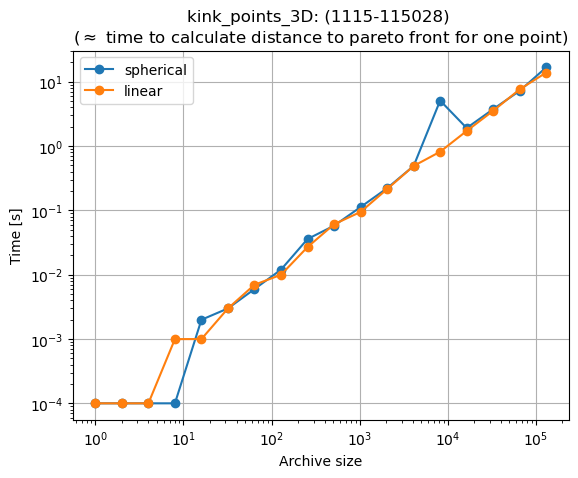

TEST KINK POINTS
         1 | 0.00099683 |
         2 | 0.00099754 |
         4 | 0.00598431 |
         8 | 0.02097678 |
        16 | 0.06881595 |
        32 | 0.37400055 |
        64 | 1.24766135 |
       128 | 4.88795590 |
       256 | 17.65277767 |
     spherical     linear
1     0.000100   0.000997
2     0.001995   0.000998
4     0.004987   0.005984
8     0.014960   0.020977
16    0.068787   0.068816
32    0.310208   0.374001
64    1.861991   1.247661
128   6.305102   4.887956
256  16.799092  17.652778


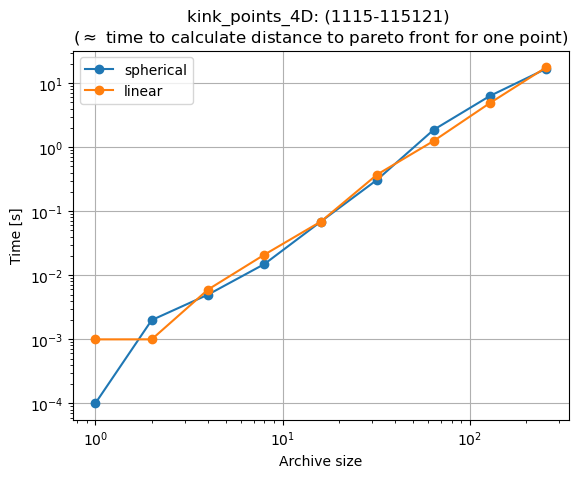

In [11]:
test_kink_points(archive_sizes, n_dim=3, time_limit=10)
plot_performance(plot_function="kink_points_3D", poly_degree=1,
                 title=r"($\approx$ time to calculate distance to pareto front for one point)")

test_kink_points(archive_sizes, n_dim=4, time_limit=10)
plot_performance(plot_function="kink_points_4D", poly_degree=2,
                 title=r"($\approx$ time to calculate distance to pareto front for one point)")


In [12]:
def test_lexsort(test_archive_sizes, n_dim=3):
    time_np = []
    time_my = []

    print("TEST LEXSORT")
    print(f"{'num points':10} | {'my lexsort':10} | {'np lexsort':10} |")
    for n in test_archive_sizes:
        pts = np.random.rand(n, n_dim)
        t0 = time.time()
        my_lexsort([pts[:, i] for i in range(n_dim)])
        t1 = time.time()
        np.lexsort([pts[:, i] for i in range(n_dim)])
        t2 = time.time()

        time_my.append(max(t1 - t0, 10e-5))
        time_np.append(max(t2 - t1, 10e-5))
        print(f"{n:10} | {t1-t0:.8f} | {t2-t1:.8f} |")
    
    save_results(data={"my_lexsort": time_my, "np_lexsort": time_np},
                 index=test_archive_sizes, n_dim=n_dim, function="lexsort")

TEST LEXSORT
num points | my lexsort | np lexsort |
         1 | 0.00000000 | 0.00000000 |
         2 | 0.00000000 | 0.00099754 |
         4 | 0.00000000 | 0.00000000 |
         8 | 0.00000000 | 0.00000000 |
        16 | 0.00000000 | 0.00000000 |
        32 | 0.00000000 | 0.00101256 |
        64 | 0.00000000 | 0.00000000 |
       128 | 0.00000000 | 0.00098801 |
       256 | 0.00000000 | 0.00000000 |
       512 | 0.00099134 | 0.00000000 |
      1024 | 0.00499129 | 0.00000000 |
      2048 | 0.00697613 | 0.00099707 |
      4096 | 0.00897598 | 0.00200772 |
      8192 | 0.02193117 | 0.00199127 |
     16384 | 0.05884719 | 0.00398469 |
     32768 | 0.15161681 | 0.00696015 |
     65536 | 0.27825546 | 0.01795101 |
    131072 | 0.55651140 | 0.03490639 |
    262144 | 1.20305395 | 0.07978630 |
    524288 | 2.42850327 | 0.17253852 |
   1048576 | 5.21755052 | 0.52456069 |
         my_lexsort  np_lexsort
1          0.000100    0.000100
2          0.000100    0.000998
4          0.000100    0.000100
8

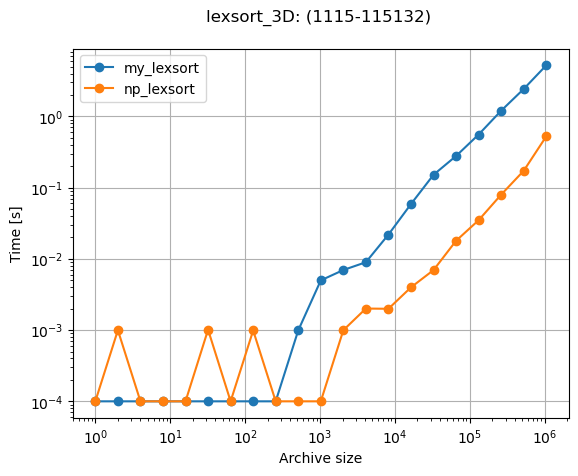

TEST LEXSORT
num points | my lexsort | np lexsort |
         1 | 0.00099993 | 0.00000000 |
         2 | 0.00000000 | 0.00000000 |
         4 | 0.00000000 | 0.00000000 |
         8 | 0.00000000 | 0.00000000 |
        16 | 0.00000000 | 0.00000000 |
        32 | 0.00000000 | 0.00000000 |
        64 | 0.00000000 | 0.00000000 |
       128 | 0.00000000 | 0.00000000 |
       256 | 0.00099659 | 0.00000000 |
       512 | 0.00000000 | 0.00000000 |
      1024 | 0.00201750 | 0.00000000 |
      2048 | 0.00300026 | 0.00000000 |
      4096 | 0.00598168 | 0.00099659 |
      8192 | 0.01097012 | 0.00199533 |
     16384 | 0.02990198 | 0.00500631 |
     32768 | 0.09371734 | 0.00997257 |
     65536 | 0.29823303 | 0.02493215 |
    131072 | 0.70311403 | 0.05687332 |
    262144 | 1.68052626 | 0.10668278 |
    524288 | 2.99360776 | 0.23540425 |
   1048576 | 5.41348672 | 1.21375060 |
         my_lexsort  np_lexsort
1          0.001000    0.000100
2          0.000100    0.000100
4          0.000100    0.000100
8

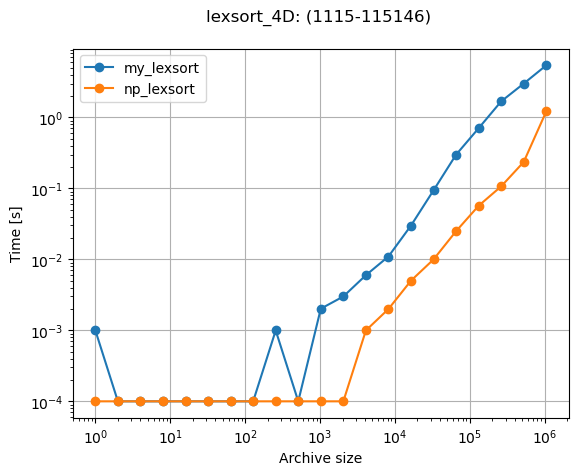

In [13]:
test_lexsort(archive_sizes, n_dim=3)
plot_performance(plot_function="lexsort_3D")

test_lexsort(archive_sizes, n_dim=4)
plot_performance(plot_function="lexsort_4D")

## Contributing hypervolume

In [14]:
def test_contributing_hypervolume(test_archive_sizes, n_dim=3, n_reps=10, time_limit=10):
    times = {
        "naive_spherical": [],
        "naive_linear": []
    }

    print("TEST CONTRIBUTING HYPERVOLUME")
    archive_sizes_tested = []
    for n_points_archive in test_archive_sizes:
        points = {
            "spherical": get_non_dominated_points(n_points_archive, mode="spherical", n_dim=n_dim),
            "linear": get_non_dominated_points(n_points_archive, mode="linear", n_dim=n_dim),
        }
        moa = {
            "spherical": get_archive(points["spherical"], [1] * n_dim),
            "linear": get_archive(points["linear"], [1] * n_dim),
        }
        
        t0 = time.time()
        _ = [moa["spherical"].contributing_hypervolume(p) for p in points["spherical"]]
        t1 = time.time()
        _ = [moa["linear"].contributing_hypervolume(p) for p in points["linear"]]
        t2 = time.time()
        
        times["naive_spherical"].append(max((t1 - t0) / n_reps, 10e-5))
        times["naive_linear"].append(max((t2 - t1) / n_reps, 10e-5))
        archive_sizes_tested.append(n_points_archive)

        print(f"{n_points_archive:10} | {times[f'naive_spherical'][-1]:.8f} | {times[f'naive_linear'][-1]:.8f} |")
        if t1 - t0 > time_limit or t2 - t1 > time_limit:
            break
    
    save_results(data=times, index=archive_sizes_tested, n_dim=n_dim, function="contributing_hypervolume")


TEST CONTRIBUTING HYPERVOLUME
         1 | 0.00010000 | 0.00010000 |
         2 | 0.00010000 | 0.00010000 |
         4 | 0.00019941 | 0.00010000 |
         8 | 0.00079803 | 0.00059826 |
        16 | 0.00319431 | 0.00308888 |
        32 | 0.01276290 | 0.01187174 |
        64 | 0.05395586 | 0.04707413 |
       128 | 0.21632462 | 0.24115837 |
       256 | 0.98356557 | 0.95357971 |
       512 | 4.22409916 | 3.81869357 |
     naive_spherical  naive_linear
1           0.000100      0.000100
2           0.000100      0.000100
4           0.000199      0.000100
8           0.000798      0.000598
16          0.003194      0.003089
32          0.012763      0.011872
64          0.053956      0.047074
128         0.216325      0.241158
256         0.983566      0.953580
512         4.224099      3.818694


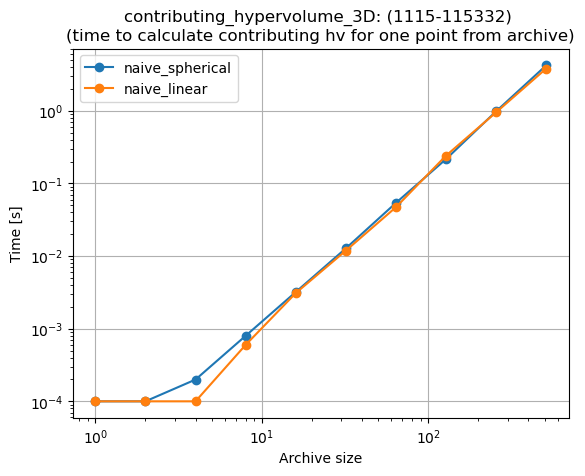

TEST CONTRIBUTING HYPERVOLUME
         1 | 0.00010000 | 0.00010000 |
         2 | 0.00010000 | 0.00010000 |
         4 | 0.00039945 | 0.00029874 |
         8 | 0.00279365 | 0.00299084 |
        16 | 0.01954772 | 0.01815133 |
        32 | 0.16964912 | 0.11179788 |
        64 | 1.02296336 | 0.86209698 |
    naive_spherical  naive_linear
1          0.000100      0.000100
2          0.000100      0.000100
4          0.000399      0.000299
8          0.002794      0.002991
16         0.019548      0.018151
32         0.169649      0.111798
64         1.022963      0.862097


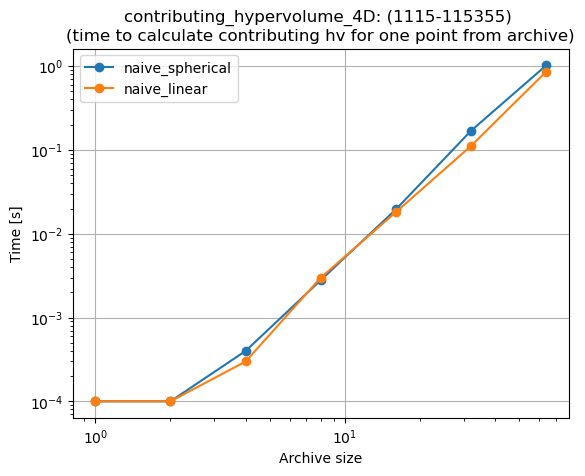

In [15]:
test_contributing_hypervolume(archive_sizes, n_dim=3, time_limit=10)
plot_performance(plot_function="contributing_hypervolume_3D",
                 title="(time to calculate contributing hv for one point from archive)")

test_contributing_hypervolume(archive_sizes, n_dim=4, time_limit=10)
plot_performance(plot_function="contributing_hypervolume_4D",
                 title="(time to calculate contributing hv for one point from archive)")

## Hypervolume improvement

In [16]:
def test_hypervolume_improvement(test_archive_sizes, time_limit=10, n_dim=3, n_reps=10):

    print("TEST HYPERVOLUME IMPROVEMENT")
    times = {
        "times_spherical": [],
        "times_linear": [],
    }
    archive_sizes_tested = []
    for n_points_archive in test_archive_sizes:
        moa = {
            "spherical": get_archive(get_non_dominated_points(n_points_archive, mode="spherical", n_dim=n_dim), [1] * n_dim),
            "linear": get_archive(get_non_dominated_points(n_points_archive, mode="linear", n_dim=n_dim), [1] * n_dim)
        }
        new_points = {
            "spherical": get_non_dominated_points(n_reps, mode="spherical", n_dim=n_dim),
            "linear": get_non_dominated_points(n_reps, mode="linear", n_dim=n_dim)
        }
                
        t0 = time.time()
        _ = [moa["spherical"].hypervolume_improvement(p) for p in new_points["spherical"]]
        t1 = time.time()
        _ = [moa["linear"].hypervolume_improvement(p) for p in new_points["linear"]]
        t2 = time.time()

        times["times_spherical"].append(max((t1 - t0) / n_reps, 10e-5))
        times[f"times_linear"].append(max((t2 - t1) / n_reps, 10e-5))
        archive_sizes_tested.append(n_points_archive)
                
        print(f"{n_points_archive:10} | {times['times_spherical'][-1]:.8f} | {times['times_linear'][-1]:.8f} |")

        if t1 - t0 > time_limit or t2 - t1 > time_limit:
            break
    
    save_results(data=times, index=archive_sizes_tested, n_dim=n_dim, function="hypervolume_improvement")

TEST HYPERVOLUME IMPROVEMENT
         1 | 0.00010000 | 0.00010000 |
         2 | 0.00010000 | 0.00010000 |
         4 | 0.00010109 | 0.00010000 |
         8 | 0.00010000 | 0.00010000 |
        16 | 0.00019948 | 0.00019951 |
        32 | 0.00020161 | 0.00029697 |
        64 | 0.00029924 | 0.00029650 |
       128 | 0.00049834 | 0.00069814 |
       256 | 0.00049856 | 0.00049868 |
       512 | 0.00109706 | 0.00119677 |
      1024 | 0.00239353 | 0.00149598 |
      2048 | 0.00359030 | 0.00369020 |
      4096 | 0.02243996 | 0.00877643 |
      8192 | 0.03270988 | 0.06921477 |
     16384 | 0.05226007 | 0.04697437 |
     32768 | 0.10880880 | 0.13553760 |
     65536 | 0.26728489 | 0.23912871 |
    131072 | 0.62353289 | 0.66203117 |
    262144 | 1.21115861 | 1.05717514 |
        times_spherical  times_linear
1              0.000100      0.000100
2              0.000100      0.000100
4              0.000101      0.000100
8              0.000100      0.000100
16             0.000199      0.000200
32

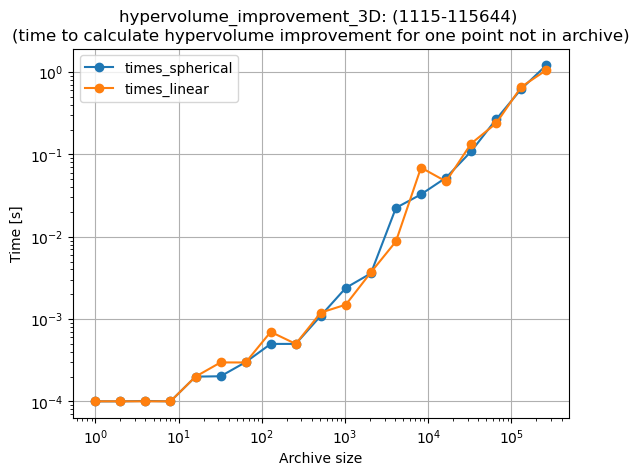

TEST HYPERVOLUME IMPROVEMENT
         1 | 0.00029922 | 0.00029914 |
         2 | 0.00069814 | 0.00060141 |
         4 | 0.00119653 | 0.00159280 |
         8 | 0.00398943 | 0.00399230 |
        16 | 0.01416225 | 0.01356373 |
        32 | 0.04807415 | 0.05135980 |
        64 | 0.18032100 | 0.14471657 |
       128 | 0.52669406 | 0.51941082 |
       256 | 1.77185993 | 1.84326553 |
     times_spherical  times_linear
1           0.000299      0.000299
2           0.000698      0.000601
4           0.001197      0.001593
8           0.003989      0.003992
16          0.014162      0.013564
32          0.048074      0.051360
64          0.180321      0.144717
128         0.526694      0.519411
256         1.771860      1.843266


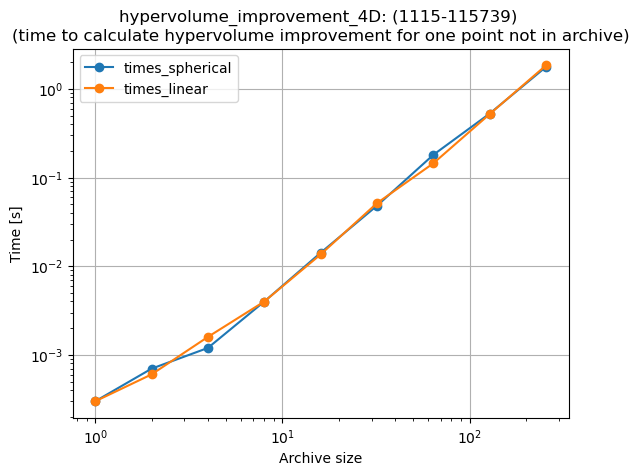

In [17]:
test_hypervolume_improvement(archive_sizes, time_limit=10, n_dim=3)
plot_performance(plot_function="hypervolume_improvement_3D",
                 title="(time to calculate hypervolume improvement for one point not in archive)")

test_hypervolume_improvement(archive_sizes, time_limit=10, n_dim=4)
plot_performance(plot_function="hypervolume_improvement_4D",
                 title="(time to calculate hypervolume improvement for one point not in archive)")